In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.decomposition import PCA
m = ['o', 's', '^', 'x']
countries = ['Argentina', 'Australia', 'Chile', 'South Africa']

# PCA in action

We saw previously a simple conceptual introduction to PCA, in that it is a method to find the vectors describing the features over which the largest spread is. 
However, it is not yet clear how it can be used for dimensionality reduction. 
For this, we will use a [real dataset](./example), which is information about 44 different wines (the data file is available [here](https://github.com/arm61/trad_ml_methods/raw/main/wine_data.csv)). 
The features we are investigating are the column in the data below, while the rows are the different wines. 

In [3]:
data = pd.read_csv('wine_data.csv')

In [4]:
data.head()

Ethanol  TotalAcid  VolatileA  MalicAcid    pH  LacticAcid  ReSugar  \
0    13.62       3.54       0.29       0.89  3.71        0.78     1.46   
1    14.06       3.74       0.59       0.24  3.73        1.25     2.42   
2    13.74       3.27       0.47      -0.07  3.87        1.13     1.52   
3    13.95       3.66       0.47       0.09  3.79        1.00     4.17   
4    14.47       3.66       0.38       0.61  3.70        0.81     1.25   

   CitricAcid         CO2  Density     FolinC  Glycerol  Methanol  TartaricA  \
0        0.31   85.610001     0.99  60.919998      9.72      0.16       1.74   
1        0.18  175.199997     1.00  70.639999     10.05      0.20       1.58   
2        0.39  513.739990     0.99  63.590000     10.92      0.18       1.24   
3        0.41  379.399994     1.00  73.300003      9.69      0.23       2.26   
4        0.14  154.880005     0.99  71.690002     10.81      0.20       1.22   

     Country  
0  Argentina  
1  Argentina  
2  Argentina  
3  Argentina  
4  Argentina

We are only printing the first 5 rows of the table, but rest assured there are 44 wines in the dataset. 

In [5]:
print(data.shape)

(44, 15)


In traditional analysis, we would investigate how individual parameters vary. 
Below, we show how the ethanol, glycerol, and methanol content varies as a function of the country that the wine is sourced from. 
However, there is no real trends present in the data.

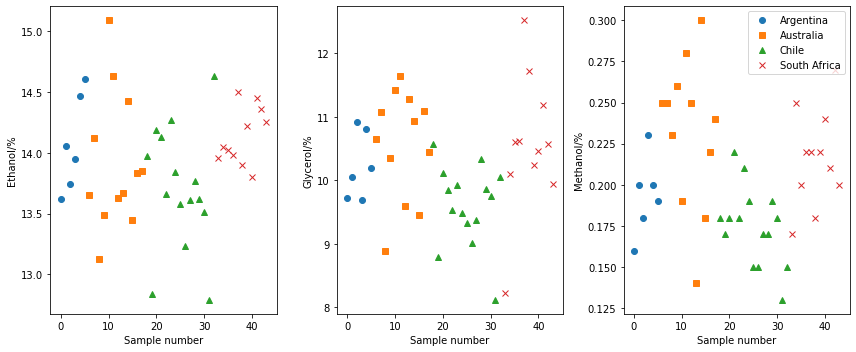

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i in range(4):
    ax[0].plot(data.where(data['Country'] == countries[i])['Ethanol'], m[i])
ax[0].set_xlabel('Sample number')
ax[0].set_ylabel('Ethanol/%')
for i in range(4):
    ax[1].plot(data.where(data['Country'] == countries[i])['Glycerol'], m[i])
ax[1].set_xlabel('Sample number')
ax[1].set_ylabel('Glycerol/%')
for i in range(4):
    ax[2].plot(data.where(data['Country'] == countries[i])['Methanol'], m[i])
ax[2].set_xlabel('Sample number')
ax[2].set_ylabel('Methanol/%')
plt.legend(labels=countries)
plt.tight_layout()
plt.show()

However, this univariate analysis process removes all covariation in the features. 
For example, if we plot the ethanol contant against the glycerol content, we can see a potentially interesting covariance. 

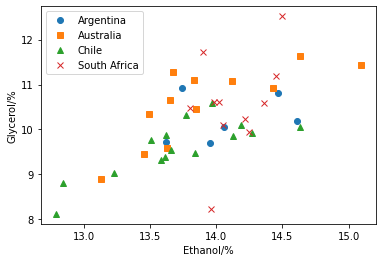

In [7]:
for i in range(4):
    plt.plot(data.where(data['Country'] == countries[i])['Ethanol'], 
             data.where(data['Country'] == countries[i])['Glycerol'], 
             m[i])
plt.xlabel('Ethanol/%')
plt.ylabel('Glycerol/%')
plt.legend(labels=countries)
plt.show()

If these two features were completely correlated, it would be possible to describe the dataset completely with a combined feature. 
Let's investigate performing a single component PCA on these two covariant features. 
First it is necessary to normalise the features such that those with large values do no overwhelm the analysis. 
This is achieved with the `sklearn.preprocessing.scale` function, we have also defined an `inverse_scale` helper function that will unnormalise the values.

In [8]:
from sklearn.preprocessing import scale

In [9]:
def inverse_scale(s, x):
    sigma = np.array(x.std(ddof=0, axis=0))
    mu = np.array(x.mean(axis=0))
    return (s * sigma.T) + mu.T

We can then reduce the relationship between ethanol and glycerol content to a single dimension. 
We then inverse transform this to visualise the effect. 

In [10]:
pca = PCA(n_components=1)
pca.fit(scale(data[['Ethanol', 'Glycerol']]))
X_pca = pca.transform(scale(data[['Ethanol', 'Glycerol']]))

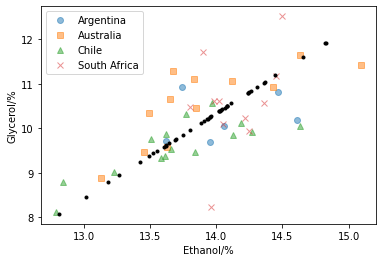

In [11]:
X_new = inverse_scale(pca.inverse_transform(X_pca), data[['Ethanol', 'Glycerol']])
for i in range(4):
    plt.plot(data.where(data['Country'] == countries[i])['Ethanol'], 
             data.where(data['Country'] == countries[i])['Glycerol'], 
             m[i], 
             alpha=0.5)
plt.plot(X_new[:, 0], X_new[:, 1], 'k.')
plt.xlabel('Ethanol/%')
plt.ylabel('Glycerol/%')
plt.legend(labels=countries)
plt.show()

Above, we have used PCA with a single component to reduce the description of the covariation of ethanol and glycerol in our wine data. 
Although, the new dataset does not completely capture the dataset that it describes, we have encoded most of the information regarding the relationship between our two features. 

In total, there are 14 features in the data (we are not considering the country that the wine is produced in as a feature as this is essentially our independent variable). 
So, how many principal components should we use to describe the measured data?

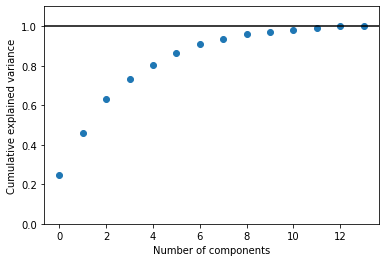

In [12]:
pca = PCA().fit(scale(data.drop('Country', axis=1)))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o')
plt.axhline(1, color='k')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.ylim(0, 1.1)
plt.show()

The plot above is a quantification of how much of the total data variance is contained within the first *N* components. 
We can see that using three components is capable of describing more than 50 % of the observed variance, while seven components are required to take this to more than 90 %. 

In [13]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.24443085 0.45713481 0.63175889 0.73170985 0.80571813 0.86427209
 0.91194903 0.93701181 0.96043195 0.97227143 0.98246275 0.99139934
 0.9992006  1.        ]


We can use a plot such as that above to determine how many components we should pay attention to. 
For simplicity going forward (so that we can use standard 2-dimensional plotting), we will only consider the first two principle components. 

In [14]:
pca = PCA(n_components=2)
pca.fit(scale(data.drop('Country', axis=1)))

PCA(n_components=2)

We can visualise the components as a function of the sample and country of origin or even the two components together.

In [15]:
X_new = pca.fit_transform(scale(data.drop('Country', axis=1)))
data['PC1'] = X_new[:, 0]
data['PC2'] = X_new[:, 1]

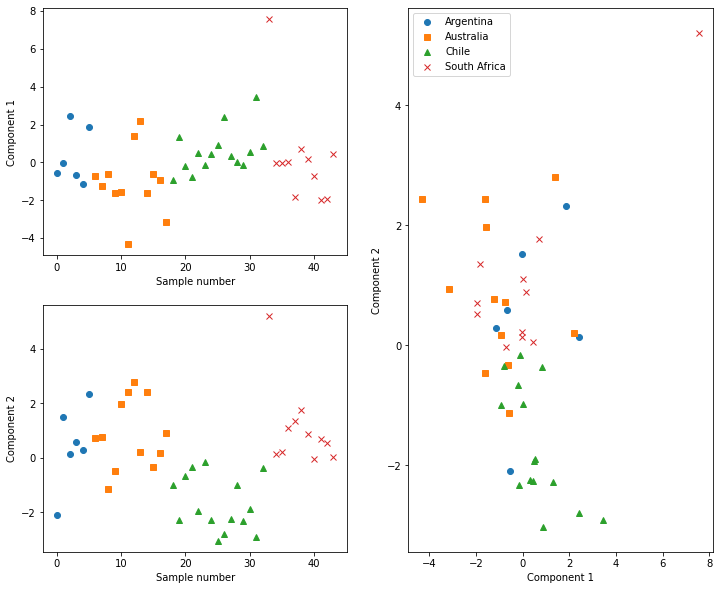

In [16]:
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2) 
ax0 = plt.subplot(gs[0, 0])
for i in range(4):
    ax0.plot(data.where(data['Country'] == countries[i])['PC1'], m[i])
ax0.set_xlabel('Sample number')
ax0.set_ylabel('Component 1')
ax1 = plt.subplot(gs[1, 0])
for i in range(4):
    ax1.plot(data.where(data['Country'] == countries[i])['PC2'], m[i])
ax1.set_xlabel('Sample number')
ax1.set_ylabel('Component 2')
ax2 = plt.subplot(gs[:, 1])
for i in range(4):
    plt.plot(data.where(data['Country'] == countries[i])['PC1'], 
             data.where(data['Country'] == countries[i])['PC2'], 
             m[i])
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
plt.legend(labels=countries)
plt.show()

From plotting the component scores, we can see that, for example, the Chilean wines typically have negative scores for component 2. 
This means that the these wines have less of the features that component 2 represents. 
Additionally, we can start to see clustering of different countries' wine in the cross component plot.
Clustering methods could potentially be applied here to classify the country of origin for new wines to our data automatically.  

Above, we mentioned that the Chilean wines appear to have less of the features that contribute to component 2. 
To understand this, it is necessary to investigate which features contribute to a given component. 
This can be achieved for our system by plotting the loadings of each feature to the component.

In [17]:
loading_matrix = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=['PC1', 'PC2'], index=data.columns[:-3])

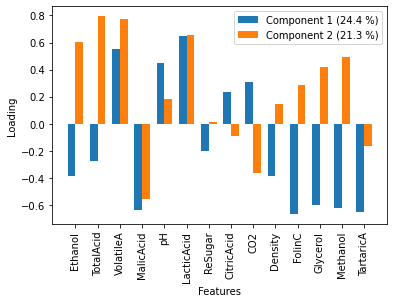

In [18]:
ind = np.arange(len(loading_matrix.index))
width = 0.35

fig, ax = plt.subplots()
ax.bar(ind, loading_matrix['PC1'], width, label='Component 1 ({:.1f} %)'.format(pca.explained_variance_ratio_[0] * 100))
ax.bar(ind + width, loading_matrix['PC2'], width, label='Component 2 ({:.1f} %)'.format(pca.explained_variance_ratio_[1] * 100))
ax.set_xlabel('Features')
ax.set_ylabel('Loading')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(loading_matrix.index)
ax.tick_params(axis='x', rotation=90)
plt.legend()
plt.show()

Since the Chilean wines had negative scores for component 2, it is implies that they have a lot of the opposite of the feature represented by component 2. 
These can be interpreted that Chilean wines have variation where ehtanol, total acid, volatile A, and lactic acid are all low, but malic acid is high. 

We will now move on to explore the application of PCA in improving edge detection. 
However, for the interested reader, we recommend the mathematical discuss of all aspects of PCA from Bro and Smilde {cite}`bro_analytical_2014` as well as the detailed introduction to PCA in Python from VanderPlas {cite}`vanderplas_python_2016`.